Run `pip install .` first to install all dependencies.

In [1]:
!pip install gcsfs==2022.10.0
!pip install wandb==0.13.4
!pip install fastparquet
!pip install numpy
!pip install pandas
!pip install catboost

     |████████████████████████████████| 1.0 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 110 kB 62.3 MB/s eta 0:00:01
     |████████████████████████████████| 138 kB 63.5 MB/s eta 0:00:01
     |████████████████████████████████| 262 kB 52.4 MB/s eta 0:00:01
     |████████████████████████████████| 161 kB 63.1 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 60.3 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 21.9 MB/s eta 0:00:01
     |████████████████████████████████| 120 kB 62.3 MB/s eta 0:00:01
     |████████████████████████████████| 409 kB 62.9 MB/s eta 0:00:01
     |████████████████████████████████| 217 kB 62.5 MB/s eta 0:00:01
ERROR: google-api-core 2.11.0 has requirement google-auth<3.0dev,>=2.14.1, but you'll have google-auth 1.5.1 which is incompatible.
ERROR: google-cloud-core 2.3.2 has requirement google-auth<3.0dev,>=1.25.0, but you'll have google-auth 1.5.1 which is incompatible.
ERROR: google-cloud-storage 2.7.0 has requireme

In [2]:
from catboost import CatBoostClassifier, Pool
import numpy as np

import gcsfs
import numpy as np
import pandas as pd

import wandb

from sklearn.preprocessing import MinMaxScaler


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
name = "classical_size_features_accuracy_branch"

# connect to weights and biases
run = wandb.init(project="thesis", job_type="dataset-creation", entity="fbv")

dataset = wandb.Artifact(name=name, type="preprocessed_data")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin


In [4]:
# import google.auth
# from google.colab import auth
# # connect to google cloud storage
# auth.authenticate_user()
# credentials, _ = google.auth.default()
fs = gcsfs.GCSFileSystem(project="thesis")
#fs = gcsfs.GCSFileSystem(project="thesis", credentials=credentials)

/usr/lib/python3/dist-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/.
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
# reduce number of imported cols due to memory issues
columns = [
    "QUOTE_DATETIME",
    "ROOT",
    "EXPIRATION",
    "STRK_PRC",
    "OPTION_TYPE",
    "TRADE_SIZE",
    "TRADE_PRICE",
    "BEST_BID",
    "BEST_ASK",
    "ask_ex",
    "bid_ex",
    "bid_size_ex",
    "ask_size_ex",
    "price_all_lead",
    "price_all_lag",
    "price_ex_lead",
    "price_ex_lag",
    "buy_sell",
]


In [56]:
train = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_extended_60.parquet",
    engine="fastparquet",
    columns=columns,
).sample(frac=0.1)
val = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_extended_20.parquet",
    engine="fastparquet",
    columns=columns,
).sample(frac=0.1)

In [57]:
from sklearn.preprocessing import MinMaxScaler#QuantileTransformer

In [58]:
# oe_option_type = OrdinalEncoder(
#     unknown_value=-1, dtype=int, handle_unknown="use_encoded_value"
# )
# oe_root = OrdinalEncoder(
#     unknown_value=-1, dtype=int, handle_unknown="use_encoded_value"
# )
# oe_issue_type = OrdinalEncoder(
#     unknown_value=-1, dtype=int, handle_unknown="use_encoded_value"
# )

scaler = MinMaxScaler(feature_range=[-1, 1])
# scaler = QuantileTransformer(n_quantiles=256)

def transform(data: pd.DataFrame) -> pd.DataFrame:

    # # date features
    x = pd.DataFrame(data={"TRADE_PRICE": data["TRADE_PRICE"]}, index=data.index)

    # log transformed features
    x[
         [
             "ask_ex",
             "bid_ex",
             "BEST_ASK",
             "BEST_BID",
             "TRADE_PRICE",
             "price_all_lag",
             "price_all_lead",
             "price_ex_lag",
             "price_ex_lead",
             "TRADE_SIZE", 
             "bid_size_ex", 
             "ask_size_ex",
         ]
     ] = data[
         [
             "ask_ex",
             "bid_ex",
             "BEST_ASK",
             "BEST_BID",
             "TRADE_PRICE",
             "price_all_lag",
             "price_all_lead",
             "price_ex_lag",
             "price_ex_lead",
             "TRADE_SIZE", 
             "bid_size_ex", 
             "ask_size_ex"
         ]
     ]
    

    # TODO: speak with caroline
    # x["bid_ex"].replace({0.0:np.NaN}, inplace=True)
    # x["ask_ex"].replace({0.0:np.NaN}, inplace=True)




    # size features
    x["bid_ask_size_ratio_ex"] = x["bid_size_ex"] / x["ask_size_ex"]
    x["rel_bid_size_ex"] = x["TRADE_SIZE"] / x["bid_size_ex"]
    x["rel_ask_size_ex"] = x["TRADE_SIZE"] / x["ask_size_ex"]
    x["depth_ex"] = x["bid_size_ex"] - x["ask_size_ex"]
    
    # classical
    mid_ex = 0.5 * (x["ask_ex"] + x["bid_ex"])
    mid_best = 0.5 * (x["BEST_ASK"] + x["BEST_BID"])
    spread_ex = (x["ask_ex"] - x["bid_ex"])
    spread_best = (x["BEST_ASK"] - x["BEST_BID"])
    
    x["prox_ex"] = (data["TRADE_PRICE"] - mid_ex) / (0.5 * spread_ex) # , (data["TRADE_PRICE"] - mid_ex) / (0.5 * spread))  # combines rel. ask ex and bid ex 
    x["prox_best"] = (data["TRADE_PRICE"] - mid_best) / (0.5 * spread_best) #, (data["TRADE_PRICE"]- mid_best) / (0.5 * spread))    



    # x["BEST_rel_bid"] = (data["TRADE_PRICE"] - mid_best) / (data["BEST_ASK"] - mid_best)
    # x["BEST_rel_ask"] = (mid_best - data["TRADE_PRICE"]) / (mid_best - data["BEST_BID"])

    
    # x["prox_ex"].clip(-10,10, inplace=True)
    # x["prox_best"].clip(-10,10, inplace=True)
    
    # some uncovered comparsions
    # x["ask_ex_best_ratio"] = x["ask_ex"]  / x["BEST_ASK"]
    # x["bid_ex_best_ratio"] = x["bid_ex"]  / x["BEST_BID"]
    # x["mid_ex_best_ratio"] = mid_ex  / mid_best
    
    # x["ex_no_trade"] = (x["ask_ex"]==0) | (x["bid_ex"]==0)
    
    x["spread_ex"] = spread_ex
    x["spread_best"] = spread_best

    x["bid_ask_ratio_ex"] = x["bid_ex"] / x["ask_ex"]
    # x["price_norm_size"] = data["TRADE_PRICE"] / data["TRADE_SIZE"]
    x["price_rel_nbb"] = (x["BEST_ASK"] - data["TRADE_PRICE"]) / (x["BEST_ASK"] - mid_best)
    x["price_rel_nbo"] = (data["TRADE_PRICE"] - x["BEST_BID"]) / (mid_best - x["BEST_BID"])
    
    # x["price_eq_ask_eq_bid"] = (data["TRADE_PRICE"] == data["ask_ex"]) & (data["TRADE_PRICE"] == data["bid_ex"])
    
    # calculate change
    x["chg_ex_lead"] = data["TRADE_PRICE"] - data["price_ex_lead"]
    x["chg_ex_lag"] = data["TRADE_PRICE"] - data["price_ex_lag"]
    x["chg_all_lead"] = data["TRADE_PRICE"] - data["price_all_lead"]
    x["chg_all_lag"] = data["TRADE_PRICE"] - data["price_all_lag"]

    # calculate change own creation
    #x["chg_ex_lag_lead"] = data["price_ex_lag"] - data["price_ex_lead"]
    #x["chg_all_lag_lead"] = data["price_all_lag"] - data["price_all_lead"]

    # impute with zeros
    x.replace([np.inf, -np.inf], np.nan, inplace=True)
    x.fillna(-1, inplace=True)

    # # scale to [-1, 1]
    # if not hasattr(scaler, "n_features_in_"):
    #     scaler.fit(x)
    # x[x.columns] = scaler.transform(x)

    # https://stackoverflow.com/questions/70727291/how-do-i-know-whether-a-sklearn-scaler-is-already-fitted-or-not

    # if not hasattr(oe_option_type, "n_features_in_"):
    #     oe_option_type.fit(data["OPTION_TYPE"].astype(str).values.reshape(-1, 1))
    # x["bin_option_type"] = oe_option_type.transform(
    #     data["OPTION_TYPE"].astype(str).values.reshape(-1, 1)
    # )

    # if not hasattr(oe_root, "n_features_in_"):
    #     oe_root.fit(data["ROOT"].astype(str).values.reshape(-1, 1))
    # x["bin_root"] = oe_root.transform(data["ROOT"].astype(str).values.reshape(-1, 1))

    # if not hasattr(oe_issue_type, "n_features_in_"):
    #     oe_issue_type.fit(data["issue_type"].astype(str).values.reshape(-1, 1))
    # x["bin_issue_type"] = oe_issue_type.transform(
    #     data["issue_type"].astype(str).values.reshape(-1, 1)
    # )

    # x.replace([np.inf, -np.inf], np.nan, inplace=True)

    x["buy_sell"] = data["buy_sell"]
    return x


In [59]:
X_train = transform(train)
y_train = X_train.buy_sell
X_train.drop(columns=["buy_sell"], inplace=True)

del train

In [60]:
X_val = transform(val)
y_val = X_val.buy_sell
X_val.drop(columns=["buy_sell"], inplace=True)
del val

In [61]:
params = {
        "od_type": "Iter",
        #"learning_rate": 0.01,
        "logging_level": "Silent",
        "loss_function": "Logloss",
        "task_type": "GPU",
        "cat_features": None,
        "random_seed": 42,
        "eval_metric":"Accuracy",
        "iterations":10000,
        "early_stopping_rounds":100,
        "grow_policy":"Lossguide"
}

#Lossguide, "grow_policy"

# lam = 0#0.25

#x = X_train.index.values / np.linalg.norm(X_train.index)
#x = (X_train.index.values - X_train.index.min()) / (X_train.index.max() - X_train.index.min())

# (v1-min(v1))/(max(v1)-min(v1))

#print(x)
# x = np.linspace(0,1, num=len(X_train))
#weight = np.exp(-lam * x)[::-1]
#weight = np.linspace(0,1, num=len(X_train))
#weight = np.geomspace(1e-4,1,num=len(X_train))
#print(weight)

model = CatBoostClassifier(**params)
train_pool = Pool(X_train, y_train,weight = X_train.index.values)
model.fit(train_pool, eval_set=(X_val,y_val))

print(model.score(X_val, y_val))

0.7475317463142745


In [63]:
# feature importances of catboost
feature_importance = model.get_feature_importance(prettified=True)
feature_importance

,Feature Id,Importances
0,bid_ask_size_ratio_ex,13.889803
1,prox_ex,13.877295
2,ask_size_ex,13.739829
3,bid_size_ex,12.508500
4,price_rel_nbb,10.276937
5,rel_bid_size_ex,5.201390
6,price_rel_nbo,4.946160
7,rel_ask_size_ex,3.670201
8,spread_ex,3.580061
9,prox_best,3.530099


In [ ]:
# 0.7434765583282902 without any scaler, zero imputer, symmetric tree
# 0.7445394305242655 "grow_policy" = "Lossguide" -> trained for 5000 iterations
# 0.7450428963013065 impute with -999 instead of 0 -> trained for 5000 iterations
# 0.7436240382023729 TODO: ask Caroline: What happens with LR if bid_ex = 0 or ask_ex is?   x["bid_ex"].replace({0.0:np.NaN}, inplace=True) and  x["ask_ex"].replace({0.0:np.NaN}, inplace=True)
# 0.7447164063731647 chg from previous trade to successive trade
# 0.7445821488326205 chg from previous trade + no trade indicator
# 0.7476558328290199 "spread" feature ex
# 0.747136093410701 "spread" feature best ex + fixed typo
# 0.7475317463142745 removed features with low importance + impute with -1

## Sanity Check against `lightgbm`

In [62]:
%%script false --no-raise-error
!pip install lightgbm

In [39]:
%%script false --no-raise-error
import lightgbm as lgb

In [40]:
%%script false --no-raise-error
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':None,
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':200,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': 42,
                    'eval_metric':'accuracy',
                    "device": "cpu",
                }

In [41]:
%%script false --no-raise-error
# create dataset for lightgbm
# if you want to re-use data, remember to set free_raw_data=False
lgb_train = lgb.Dataset(X_train, y_train,weight=X_train.index.values, free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train, free_raw_data=False)

In [42]:
%%script false --no-raise-error
bst = lgb.LGBMClassifier(**lgb_params)
bst = lgb.train(lgb_params,
                train_set=lgb_train,
                valid_sets=lgb_eval,
                early_stopping_rounds=100
)

In [43]:
%%script false --no-raise-error
pred = bst.predict(X_val)
pred = np.rint(pred)
pred[pred==0]=-1
print((y_val == pred).mean())

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2675a8640>,
      dtype=object)

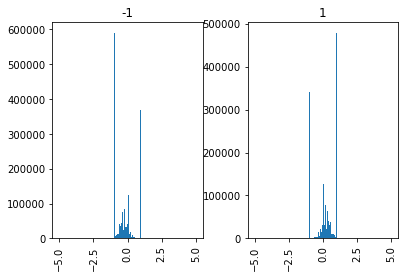

In [44]:
X_train.prox_ex.hist(bins=128, range=[-5,5], by=y_train)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd238b9c370>,
      dtype=object)

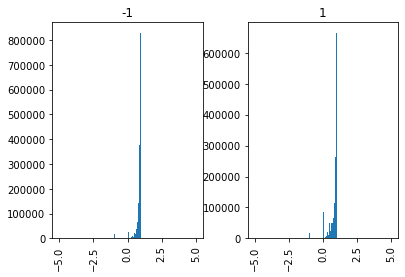

In [45]:
X_train["bid_ask_ratio_ex"].hist(bins=128, range=[-5,5], by=y_train)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd238ad3e50>,
      dtype=object)

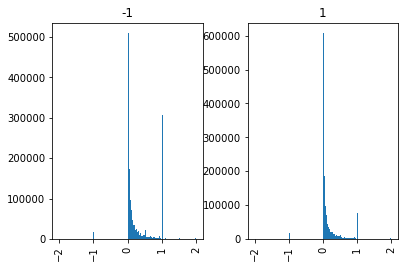

In [46]:
X_train["rel_ask_size_ex"].hist(bins=128, range=[-2,2], by=y_train)

## Results

In [21]:
# 0.7434765583282902 without any scaler, zero imputer, symmetric tree
# 0.7445394305242655 "grow_policy" = "Lossguide" -> trained for 5000 iterations
# 0.7450428963013065 impute with -999 instead of 0 -> trained for 5000 iterations
# 0.7436240382023729 TODO: ask Caroline: What happens with LR if bid_ex = 0 or ask_ex is?   x["bid_ex"].replace({0.0:np.NaN}, inplace=True) and  x["ask_ex"].replace({0.0:np.NaN}, inplace=True)
# 0.7447164063731647 chg from previous trade to successive trade
# 0.7445821488326205 chg from previous trade + no trade indicator
# 0.7476558328290199 "spread" feature ex
# 0.747136093410701 "spread" feature best ex + fixed typo


In [22]:
# 0.7333797810178145 (logs applied) to     x["bid_ask_size_ratio_ex"] x["rel_bid_size_ex"]   x["rel_ask_size_ex"] 
# 0.7331946683482763 (all from above + log returns)
# 0.734859665271541 (all above + compare mids, ask, and bid at exchange with nation wide)
# 0.7349013664773161 (all above + trade_price == bid_ex == ask_ex)
# 0.7351464881990674 (price normed size)
# 0.7352807457396116 (all above +  x["price_rel_nbo"] +  x["price_rel_nbb"])
# 0.74296292 (some removed, see above, max. iterations reached. Actually there is no reason to stop ensemble)
# 0.745053067 convert some ratios to percentages (all other things the same as above)
# robust scaler with log (ca. 74.4)
# robust scaler without log 0.74342061

# 0.74356606
# 0.74381220